In [581]:
import numpy as np
import pandas as pd

import urllib.request
import zipfile
import os
import pickle

import datetime
import logging
import math
import random
import time
from typing import Tuple, Type
import logging
from abc import ABCMeta, abstractmethod
random.seed(612018)

In [582]:
movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
download_path = "/content/movielens"

os.makedirs(download_path, exist_ok=True)
zip_file_path = os.path.join(download_path, "ml-latest.zip")
urllib.request.urlretrieve(movielens_url, zip_file_path)

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(download_path)

extracted_files = os.listdir(download_path)
print("Files in the extracted directory:", extracted_files)

Files in the extracted directory: ['ml-latest-small', 'ml-latest.zip']


In [583]:
class ModelException(Exception):
    pass

In [584]:
class Model:
    PARAMS = None
    __metaclass__ = ABCMeta

    def __init__(self, *args):
        pass

    @abstractmethod
    def train(self, *args):
        pass

    @abstractmethod
    def predict(self, *args):
        pass

    @abstractmethod
    def get_params(self):
        pass

    def pickle_parameters(self, file_name, full_path = None, default_folder = "MODEL_PARAMS"):
        try:
            if full_path is not None:
                path = f"{full_path}/{file_name}.pickle"
            else:
                os.mkdir(default_folder)
                path = f"{os.getcwd()}/{default_folder}/{file_name}.pickle"

            with open(path, "wb") as handle:
                pickle.dump(self.PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

            print(f"Parameters saved successfully at {path}")
            return path

        except Exception as error:
            print("Failed to save parameters")
            return "FAILURE"

    def load_parameters(self, file_path):
        try:
            with open(file_path, "rb") as handle:
                self.PARAMS = pickle.load(handle)
            return True

        except Exception as error:
            return False


In [585]:
class Generic:
    b_u = None
    alpha_u = None
    b_i = None
    c_u = None
    b_ut = None
    c_ut = None
    b_ibin = None
    p = None
    q = None
    alpha_p = None
    __metaclass__ = ABCMeta

    def __init__(self, b_u, alpha_u, b_i, c_u, b_ut, c_ut, b_ibin, p, q, alpha_p):
        self.b_u = b_u
        self.alpha_u = alpha_u
        self.b_i = b_i
        self.c_u = c_u
        self.b_ut = b_ut
        self.c_ut = c_ut
        self.b_ibin = b_ibin
        self.p = p
        self.q = q
        self.alpha_p = alpha_p

In [586]:
class Gradients(Generic):
    def __init__(self, b_u, alpha_u, b_i, c_u, b_ut, c_ut, b_ibin, p, q, alpha_p):
        super().__init__(b_u=b_u, alpha_u=alpha_u, b_i=b_i, c_u=c_u, b_ut=b_ut, c_ut=c_ut, b_ibin=b_ibin, p=p, q=q, alpha_p=alpha_p)

In [587]:
class LearningRates(Generic):
    b_u = 3e-3
    alpha_u = 1e-5
    b_i = 2e-3
    c_u = 8e-3
    b_ut = 25e-4
    c_ut = 2e-3
    b_ibin = 5e-5
    p = 5e-3
    q = 5e-3
    alpha_p = 1e-4

In [588]:
class Parameters(object):
    alpha_p = dict()
    alpha_u = dict()
    b_i = dict()
    b_ibin = np.array([])
    b_u = dict()
    b_ut = np.array([])
    c_u = dict()
    c_ut = np.array([])
    p = dict()
    q = dict()

In [589]:
class RegularisationRates(Generic):
    b_u = 3e-2
    alpha_u = 50
    b_i = 3e-2
    c_u = 1e-2
    b_ut = 5e-3
    c_ut = 5e-3
    b_ibin = 1e-1
    p = 5e-4
    q = 5e-4
    alpha_p = 1e-4

In [590]:
class RowSettings(Generic):
    User = None
    Movie = None
    Rating = None
    BinVal = None
    Time = None
    Dev = None
    time_index = None

    def __init__(self, user, movie, binval, time, rating, b_u, alpha_u, b_i, c_u, b_ut, c_ut, b_ibin, p, q, alpha_p, time_index):
        super().__init__(b_u=b_u, alpha_u=alpha_u, b_i=b_i, c_u=c_u, b_ut=b_ut, c_ut=c_ut, b_ibin=b_ibin, p=p, q=q, alpha_p=alpha_p)
        self.User = user
        self.Movie = movie
        self.BinVal = binval
        self.Time = time
        self.Rating = rating
        self.time_index = time_index

    def set_dev(self, dev):
        self.Dev = dev


In [591]:
class BellkorAlgorithm(Model):
    PIVOTDF = None
    PARAMS = Parameters
    START_TIME = None
    END_TIME = None
    LEARNING_RATES = LearningRates
    REGULARISATION = RegularisationRates
    GLOBAL_MEAN = None
    USERS = None
    ITEMS = None
    TIME_RANGE = None
    TIME_DIFF = None

    # Optimisation Values
    COST = 0
    TOTAL_ERROR = 0
    NUM = 0

    def __init__(self, df, n_items, n_users, global_mean = None, time_setting = dict(Start=None, End=None), matrix_size= 20):
        super().__init__()

        # Create the Arrays of Users and Item Lists
        self.USERS = np.arange(n_users)
        self.ITEMS = np.arange(n_items)
        self.PIVOTDF = df
        self.errors = []

        # Update the Global Mean Parameter
        if global_mean is not None:
            self.GLOBAL_MEAN = global_mean

        # Set the Time parameters
        if time_setting["Start"] is not None and time_setting["End"] is not None:
            self.START_TIME = int(time_setting["Start"])
            self.END_TIME = int(time_setting["End"])
            self.TIME_DIFF = self.END_TIME - self.START_TIME
            dt_rng = list(
                map(lambda x: int(time.mktime(x.timetuple())), pd.date_range(start=datetime.datetime.fromtimestamp(self.START_TIME), end=datetime.datetime.fromtimestamp(self.END_TIME), freq="D").tolist()))
            self.TIME_RANGE = np.arange(len(dt_rng))
            self.TIME_MAP = dict(zip(dt_rng, np.arange(self.TIME_RANGE.shape[0])))

        # Define the User Parameters
        for user in self.USERS:
            # For each User add their Parameters
            self.PARAMS.b_u[user] = 0
            self.PARAMS.alpha_u[user] = 0
            self.PARAMS.c_u[user] = 1
            self.PARAMS.p[user] = np.random.rand(matrix_size) * 1e-2
            self.PARAMS.alpha_p[user] = np.random.rand(matrix_size) * 1e-2

        # Create the Time bases User parameters
        self.PARAMS.b_ut = np.zeros(
            shape=(self.USERS.shape[0], self.TIME_RANGE.shape[0])
        )
        self.PARAMS.c_ut = self.PARAMS.b_ut.copy()

        # Define the Items Parameters
        for item in self.ITEMS:
            self.PARAMS.b_i[item] = 0
            self.PARAMS.q[item] = np.random.rand(matrix_size) * 1e-2

        # Create the Time based params for each Item
        self.PARAMS.b_ibin = np.tile(np.arange(30), reps=(self.ITEMS.shape[0], 1)) / 100

        # Validate the Algorithm has been instantiated correctly
        self._validation()

    def _validation(self):
        if self.START_TIME is None or self.END_TIME is None:
            raise ModelException("No time constants are known")

        if self.TIME_DIFF is None:
            raise ModelException("Time difference hasn't been calculated")

        if self.GLOBAL_MEAN is None:
            raise ModelException("Global Mean is not known")

        if self.USERS is None or self.ITEMS is None:
            raise ModelException("Users or Items directory have not been initialised correctly")

        if self.COST != 0 or self.TOTAL_ERROR != 0 or self.NUM != 0:
            self.COST, self.TOTAL_ERROR, self.NUM = 0, 0, 0

    def override_rates(self, lr = None, reg = None):
        if lr is not None:
            self.LEARNING_RATES = lr

        if reg is not None:
            self.REGULARISATION = reg

    def predict(self, x, average_times):
        # Early return if no data exists
        if x.shape[0] == 0:
            return np.array([])

        # Collect the Results
        collected_results, t1 = [], time.time()

        for each_index in range(len(x)):
            # Get the Row Settings
            rs = self.get_row_settings(inputs=x[int(each_index), :])

            # Run the Bellkor Algorithm
            prediction, updated_rs = self.run_bellkor(rs=rs, average_times=average_times)

            # Collect Result
            collected_results.append([each_index, prediction])

        # Return Results
        return np.array(collected_results)

    def train(self, x, average_times, sample_size = 1000, iterations = 10):
        # Check that the number of Iterations is greater or less than 1
        if iterations <= 0:
            raise ModelException("Incorrect amount of Iterations passed to method")
        else:
            self.NUM = 0

        # Iterate through each Epoch
        for epoch in np.arange(start=0, stop=iterations):
            
            self.TOTAL_ERROR = 0

            # Sample from the Training Set Index
            for each_index in np.random.choice(x[:, 0], sample_size):

                # Get the given Row
                rs = self.get_row_settings(inputs=x[int(each_index), :])

                # Run the Bellkor Algorithm
                prediction, updated_rs = self.run_bellkor(rs=rs, average_times=average_times)
                self.NUM += 1

                # Compute the Cost
                error = self.compute_cost(rating=rs.Rating, prediction=prediction, rs=updated_rs)
                
                self.TOTAL_ERROR += error**2

                # Update the parameters by Gradient Descent
                self.gradient_descent(error=error, rs=updated_rs)
            
            self.errors.append(np.sqrt(self.TOTAL_ERROR/sample_size))

        # Return Results
        return self.COST / self.NUM, self.errors

    def run_bellkor(self, rs, average_times):
        # Find the difference from the Average Review data
        delta = rs.Time - average_times[rs.User]

        # Find the Sign
        sign = -1 if delta < 0 else 1

        # Rescale
        delta = abs(delta) / self.TIME_DIFF

        # Find the 'deviation'
        dev = sign * math.pow(delta, 0.4)
        rs.set_dev(dev=dev)

        # Find p
        p = rs.p + rs.alpha_p * dev

        # Calculate the Model Prediction
        output = self.GLOBAL_MEAN + rs.b_u + (rs.alpha_u * dev) + rs.b_ut + ((rs.b_i + rs.b_ibin) * (rs.c_u + rs.c_ut)) + np.dot(rs.q.T, (p+1e-3*self.PIVOTDF[rs.User-1]))
        # print(output)
        return output, rs

    def compute_cost(self, rating, prediction, rs):
        # Calculate the Error
        error = rating - prediction

        # Calculate the Cost
        self.COST += error ** 2

        # Include the Regularisation Terms too
        self.COST += (self.REGULARISATION.b_u * (rs.b_u ** 2)) + (self.REGULARISATION.alpha_u * (rs.alpha_u ** 2)) + (self.REGULARISATION.b_ut * (rs.b_ut ** 2)) + (self.REGULARISATION.b_i * (rs.b_i ** 2)) + (self.REGULARISATION.b_ibin * (rs.b_ibin ** 2)) + (self.REGULARISATION.c_u * (rs.c_u - 1) ** 2) + (self.REGULARISATION.c_ut * (rs.c_ut ** 2)) + (self.REGULARISATION.p * (rs.p ** 2)) + (self.REGULARISATION.q * (rs.q ** 2)) + (self.REGULARISATION.alpha_p * (rs.alpha_p ** 2))
        return error

    def gradient_descent(self, error, rs):
        # Compute the Gradients
        grads = self.get_gradients(rs=rs, error=error)

        self.PARAMS.b_u[rs.User] -= self.LEARNING_RATES.b_u * grads.b_u
        self.PARAMS.alpha_u[rs.User] -= self.LEARNING_RATES.alpha_u * grads.alpha_u
        self.PARAMS.b_i[rs.Movie] -= self.LEARNING_RATES.b_i * grads.b_i
        self.PARAMS.c_u[rs.User] -= self.LEARNING_RATES.c_u * grads.c_u
        self.PARAMS.b_ut[rs.User, rs.time_index] -= self.LEARNING_RATES.b_ut * grads.b_ut
        self.PARAMS.c_ut[rs.User, rs.time_index] -= self.LEARNING_RATES.c_ut * grads.c_ut
        self.PARAMS.b_ibin[rs.Movie, rs.BinVal] -= self.LEARNING_RATES.b_ibin * grads.b_ibin
        self.PARAMS.p[rs.User] -= self.LEARNING_RATES.p * grads.p
        self.PARAMS.q[rs.Movie] -= self.LEARNING_RATES.q * grads.q
        self.PARAMS.alpha_p[rs.User] -= self.LEARNING_RATES.alpha_p * grads.alpha_p

    def get_params(self):
        return self.PARAMS

    def get_row_settings(self, inputs):
        # Row Values
        user = int(inputs[2])
        movie = int(inputs[3])
        time_val = inputs[1]
        binval = int((time_val - self.START_TIME) / (self.TIME_DIFF / 30))

        # Get datetime Index
        time_index = int(time.mktime(datetime.datetime.fromtimestamp(time_val).date().timetuple()))
        time_index = int(self.TIME_MAP[time_index])

        # Collate the Row Settings
        rs = RowSettings(user=user, movie=movie, rating=inputs[4], binval=binval, time=time_val, time_index=time_index, b_u=self.PARAMS.b_u[user], alpha_u=self.PARAMS.alpha_u[user], b_i=self.PARAMS.b_i[movie], c_u=self.PARAMS.c_u[user], b_ut=self.PARAMS.b_ut[user, time_index], c_ut=self.PARAMS.c_ut[user, time_index], b_ibin=self.PARAMS.b_ibin[movie - 1, binval], p=self.PARAMS.p[user], q=self.PARAMS.q[movie], alpha_p=self.PARAMS.alpha_p[user])
        return rs


    def get_gradients(self, rs, error):
        # Calculate all the Gradients for each Parameter
        gradients = Gradients(
            b_u=-2 * error + 2 * self.REGULARISATION.b_u * rs.b_u,
            alpha_u=2 * error * (-rs.Dev)
            + 2 * self.REGULARISATION.alpha_u * rs.alpha_u,
            b_ut=2 * error * (-1) + self.REGULARISATION.b_ut * rs.b_ut,
            b_i=2 * error * (-rs.c_u - rs.c_ut) + 2 * self.REGULARISATION.b_i * rs.b_i,
            b_ibin=2 * error * (-rs.c_u - rs.c_ut)
            + 2 * self.REGULARISATION.b_ibin * rs.b_ibin,
            c_u=2 * error * (-rs.b_i - rs.b_ibin)
            + 2 * self.REGULARISATION.c_u * (rs.c_u - 1),
            c_ut=2 * error * (-rs.b_i - rs.b_ibin)
            + 2 * self.REGULARISATION.c_ut * rs.c_ut,
            p=2 * error * (-rs.q) + 2 * self.REGULARISATION.p * rs.p,
            q=2 * error * (-rs.p - rs.alpha_p * rs.Dev)
            + 2 * self.REGULARISATION.q * rs.q,
            alpha_p=2 * error * (-rs.q * rs.Dev)
            + self.REGULARISATION.alpha_p * rs.alpha_p,
        )
        return gradients

In [592]:
data_location = os.getcwd()+'bellkor'
datasets = [f for f in os.listdir(data_location) if f.endswith(".csv")]
print("Files in the data location: ", datasets)

Files in the data location:  ['links.csv', 'movies.csv', 'ratings.csv', 'tags.csv']


In [593]:
tags = pd.read_csv("{}/tags.csv".format(data_location))
tags.head(n=3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [594]:
links = pd.read_csv("{}/links.csv".format(data_location))
links.head(n=3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [595]:
ratings = pd.read_csv("{}/ratings.csv".format(data_location))
print(ratings.shape)
ratings.head(n=3)


(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [596]:
df = ratings.drop(['timestamp'],axis=1)
df = df.pivot_table(index="userId", columns="movieId", values="rating").reindex(columns=df.index, fill_value=np.nan)
df

,0,1,2,3,4,5,6,7,8,9,...,100826,100827,100828,100829,100830,100831,100832,100833,100834,100835
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [597]:
nus = np.zeros((len(df)))
for i in range(nus.shape[0]):
    row = df.iloc[i]
    row = row.dropna()
    row = np.asarray(row.values)
    nu = row.shape[0]
    su = np.sum(row)
    su = su/nu
    nus[i] = su
nus

array([4.36637931, 3.95454545, 2.43589744, 3.55555556, 3.63636364,
       3.49363057, 3.23026316, 3.57446809, 3.26086957, 3.28512397,
       3.78125   , 4.390625  , 3.64516129, 3.39583333, 3.5       ,
       3.7244898 , 4.20952381, 3.71809745, 2.60739687, 3.59090909,
       3.33846154, 2.57142857, 3.64876033, 3.65841584, 4.86111111,
       3.23809524, 3.54814815, 3.02017544, 4.14102564, 4.74074074,
       3.92      , 3.75490196, 3.78846154, 3.41860465, 4.08695652,
       2.63333333, 4.14285714, 3.21794872, 4.        , 3.76699029,
       3.32010582, 3.56590909, 4.55263158, 3.35416667, 3.87593985,
       4.        , 3.04424779, 4.03030303, 4.25      , 2.94545455,
       3.77576602, 4.43589744, 5.        , 3.03030303, 2.84      ,
       3.80434783, 3.39285714, 3.90178571, 4.35514019, 3.72727273,
       4.05128205, 4.10271318, 3.60116732, 3.7688588 , 4.03333333,
       4.02028986, 3.97142857, 3.22140523, 4.36956522, 4.32258065,
       3.6       , 4.15555556, 3.76100629, 4.27118644, 3.23188

In [598]:
movies = pd.read_csv("{}/movies.csv".format(data_location))
movies.head(n=3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [599]:
global_mean = ratings["rating"].mean()
print("Global Mean Rating: {} stars".format(global_mean))

Global Mean Rating: 3.501556983616962 stars


In [600]:
distinct_users = ratings["userId"].unique()
user_count = distinct_users.shape[0]
print("Number of Users found: {}".format(user_count))
user_mapping = dict(zip(distinct_users, np.arange(user_count)))

Number of Users found: 610


In [601]:
ratings.loc[:, "UserId"] = ratings.loc[:, "userId"].apply(lambda x: user_mapping[x])
distinct_movies = ratings["movieId"].unique()
movie_count = distinct_movies.shape[0]
print("Number of Movies found: {}".format(movie_count))
movie_mapping = dict(zip(distinct_movies, np.arange(movie_count)))

Number of Movies found: 9724


In [602]:
ratings.loc[:, "MovieId"] = ratings.loc[:, "movieId"].apply(lambda x: movie_mapping[x])
start_time = ratings["timestamp"].min()
end_time = ratings["timestamp"].max()
print("Start Timestamp {}, End Timestamp {}".format(start_time, end_time))
print(datetime.datetime.fromtimestamp(end_time))

Start Timestamp 828124615, End Timestamp 1537799250
2018-09-24 19:57:30


In [603]:
adjusted_start_day = int(time.mktime(datetime.datetime.fromtimestamp(start_time).date().timetuple()))
adjusted_end_day = int(time.mktime(datetime.datetime.fromtimestamp(end_time).date().timetuple())) + 86400

In [604]:
average_df = ratings.groupby("UserId")["timestamp"].mean().reset_index()
average_df.head(n=3)

,UserId,timestamp
0,0,9.649856e+08
1,1,1.445715e+09
2,2,1.306464e+09


In [605]:
average_times = pd.Series(average_df.timestamp.values, index=average_df.UserId).to_dict()
ratings.describe()

,userId,movieId,rating,timestamp,UserId,MovieId
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557,1.205946e+09,325.127564,1855.988248
std,182.618491,35530.987199,1.042529,2.162610e+08,182.618491,2000.247662
min,1.000000,1.000000,0.500000,8.281246e+08,0.000000,0.000000
25%,177.000000,1199.000000,3.000000,1.019124e+09,176.000000,461.000000
50%,325.000000,2991.000000,3.500000,1.186087e+09,324.000000,1134.000000
75%,477.000000,8122.000000,4.000000,1.435994e+09,476.000000,2510.000000
max,610.000000,193609.000000,5.000000,1.537799e+09,609.000000,9723.000000


In [606]:
# Checking if any nulls or NaN exist in any of the columns
ratings.count() == ratings.shape[0]

userId       True
movieId      True
rating       True
timestamp    True
UserId       True
MovieId      True
dtype: bool

In [607]:
ratings.head(n=5)

,userId,movieId,rating,timestamp,UserId,MovieId
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [608]:
calibrator = BellkorAlgorithm(nus,n_items=movie_count, n_users=user_count, global_mean=global_mean, time_setting=dict(Start=adjusted_start_day, End=adjusted_end_day))

In [609]:
ratings.loc[:, "Index"] = ratings.index
ratings.head(n=3)

,userId,movieId,rating,timestamp,UserId,MovieId,Index
0,1,1,4.0,964982703,0,0,0
1,1,3,4.0,964981247,0,1,1
2,1,6,4.0,964982224,0,2,2


In [610]:
X = ratings.loc[:, ["Index", "timestamp", "UserId", "MovieId", "rating"]].values

split = int(0.8*X.shape[0])

X_train = X[0:split-1, :]
X_test = X[split:, :]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (80667, 5)
Test size: (20168, 5)


In [611]:
ratings

,userId,movieId,rating,timestamp,UserId,MovieId,Index
0,1,1,4.0,964982703,0,0,0
1,1,3,4.0,964981247,0,1,1
2,1,6,4.0,964982224,0,2,2
3,1,47,5.0,964983815,0,3,3
4,1,50,5.0,964982931,0,4,4
...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120,100831
100832,610,168248,5.0,1493850091,609,2035,100832
100833,610,168250,5.0,1494273047,609,3121,100833
100834,610,168252,5.0,1493846352,609,1392,100834


In [612]:
cost, error = calibrator.train(x=X_train, average_times=average_times, sample_size=X_train.shape[0], iterations=200)

In [616]:
# print(X_test[0,0])
preds = calibrator.predict(x=X_test, average_times=average_times)
predictions = pd.DataFrame(data=preds, columns=["Index", "Prediction"])
correct = X_test[:,4:][:,0]
print("RMSE LOSS on the test-set: ",np.sqrt(np.sum(np.square(correct-preds[:,1]))/X_test.shape[0]))

RMSE LOSS on the test-set:  1.0451469102311977


In [617]:
predictions

,Index,Prediction
0,0.0,3.564641
1,1.0,3.265729
2,2.0,2.711789
3,3.0,3.445605
4,4.0,2.787496
...,...,...
20163,20163.0,3.787966
20164,20164.0,4.140534
20165,20165.0,3.929384
20166,20166.0,4.176209


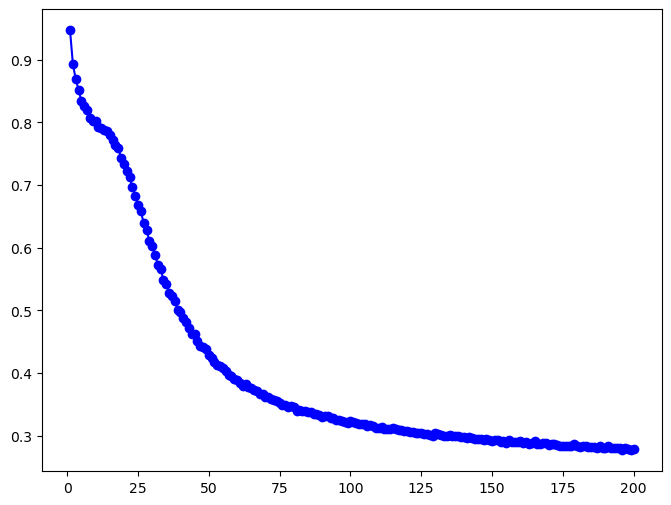

In [622]:
import matplotlib.pyplot as plt

x_values = range(1, len(error) + 1)

# Plotting the errors as a line plot
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, error, marker='o', linestyle='-', color='blue')